In [1]:
%matplotlib inline
import pandas as pd
from numpy import cos, sin, array,radians
import numpy as np
import matplotlib.pyplot as plt
import re
regex = re.compile('[^a-zA-Z]')
import string 
alphabet = string.ascii_letters

In [2]:
def aportan_a_nodo(Nodo):    
    xjs = [Nodo[0]] + [Nodo[0]+1]
    yis = [Nodo[1]-1] + [Nodo[1]]
    try:
        del ady_horizontal, below_vertical, above_vertical
    except:pass

    try:
        ady_horizontal = horizontal[int(np.array(list(range(len(horizontal))))[NivelHorizontal=='Nivel %d'%Nodo[1]])]
    except:pass

    try:
        above_vertical = vertical[int(np.array(list(range(len(vertical))))[NivelVertical=='Nivel %d'%(Nodo[1])])]
    except:pass
    
    try:
        below_vertical = vertical[int(np.array(list(range(len(vertical))))[NivelVertical=='Nivel %d'%(Nodo[1]-1)])]
        
    except:pass

    aportan = []
    columns = []
    try:
        df_aportan = ady_horizontal[(ady_horizontal['Xj'].values==xjs[0])|(ady_horizontal['Xj'].values==xjs[1])]
        c = 0
        for i, row in df_aportan.iterrows():
            columns.append((['j', df_aportan['N'].values[c]] if Nodo[0]==row['Xj'] else ['i', df_aportan['N'].values[c]]) + [int(df_aportan['Nodo i'].values[c]), int(df_aportan['Nodo j'].values[c])])
            c+=1
        aportan.append(df_aportan)
    except:pass

    try:
        df_aportan = above_vertical[(above_vertical['Xi'].values==Nodo[0])]
        aportan.append(df_aportan)
        columns.append(['j', int(df_aportan['N'].values), int(df_aportan['Nodo i'].values), int(df_aportan['Nodo j'].values)])
        
    except:pass
    
    try:
        df_aportan = below_vertical[(below_vertical['Xi'].values==Nodo[0])]
        aportan.append(df_aportan)
        
        columns.append(['i', int(df_aportan['N'].values), int(df_aportan['Nodo i'].values), int(df_aportan['Nodo j'].values)])
    except:pass
    
    return columns

In [3]:
def enumerar(vector, df):
    global horizontal, vertical, NivelHorizontal, NivelVertical
    #print('Horizontal')
    C = 1
    horizontal = []
    for _, esto in sorted(pd.DataFrame(vector).groupby(1), reverse=True):  # to_concat
        if _!=0:
            esto.index.name = "Nivel %d"%_
            esto = esto.sort_values(0)
            esto[2] = [[np.nan]] + [[i, j] for i, j in zip(esto[0].values[:-1], esto[0].values[1:])]
            tmp = [np.nan]
            for i in range(len(esto)-1):
                tmp.append(C)
                C += 1
            esto[3] = tmp
            esto = esto.dropna()
            esto[3] = esto[3].astype(int)
            esto[4] = np.zeros(len(esto))*np.nan
            for _, i in esto.iterrows():
                esto.loc[_, 4] = df[(df[0]==i[0])&(df[1]==i[1])][2].values
            esto[4] = esto[4].astype(int)
            esto[5] = esto[4].values - 1
            esto.columns = ['Xj', 'Yj', 'InicioFin', 'N', 'Nodo j', 'Nodo i']
            #print(esto, '\n')
            horizontal.append(esto)

    NivelHorizontal = np.array([i.index.name for i in horizontal])
    #print('Vertical')

    to_concat = []
    for _, esto in pd.DataFrame(vector).groupby(0):  # Vertical
        esto = esto.sort_values(1)
        esto[4] = [np.nan] + [i for i, j in zip(esto[1].values[:-1], esto[1].values[1:])]
        esto[2] = [np.nan] + [[i, j] for i, j in zip(esto[1].values[:-1], esto[1].values[1:])]
        to_concat.append(esto.dropna())

    vertical = []
    for _, esto in sorted(pd.concat(to_concat).groupby(4), reverse=True):
        del esto[4]
        esto.index.name = "Nivel %d"%_
        esto = esto.sort_values(0)
        tmp = []
        for i in range(len(esto)):
            tmp.append(C)
            C += 1
        esto[3] = tmp
        esto[4] = np.zeros(len(esto))*np.nan
        esto[5] = np.zeros(len(esto))*np.nan
        for _, i in esto.iterrows():
            esto.loc[_, 4] = df[(df[0]==i[0])&(df[1]==i[1])][2].values
            esto.loc[_, 5] = df[(df[0]==i[0])&(df[1]==i[1]-1)][2].values
        esto[4] = esto[4].astype(int)
        esto[5] = esto[5].astype(int)
        esto.columns = ['Xi', 'Yi', 'InicioFin', 'N', 'Nodo i', 'Nodo j']
        #print(esto, '\n')
        vertical.append(esto)
    NivelVertical = np.array([i.index.name for i in vertical])

In [4]:
class Edificio:
    def __init__(self, Lc, luces, hc, bc, hv, bv, Ec, Ev, alphac,alphav, pisos):
        self.Lc = Lc
        self.hc = hc
        self.bc = bc
        self.hv = hv
        self.bv = bv
        self.Ac = hc * bc
        self.Av = hv * bv
        self.Ic = bc * (hc**3) / 12
        self.Iv = bv * (hv**3) / 12
        self.Ec = Ec
        self.Ev = Ev
        self.pisos = pisos
        self.alphav = radians(alphav)
        self.alphac = radians(alphac)
        self.luces = dict(zip(('x', 'y'), luces))   
        self.xy_columnas = {}
        self.condensadas = {}
        
    def calc_lambda(self, alpha):
        """
        Calcula la matriz de rotación para el ángulo especificado
        """
        self.lamb = array([[ cos(alpha), sin(alpha), 0],
                           [-sin(alpha), cos(alpha), 0],
                           [     0     ,     0     , 1]])
        return self.lamb

    def calc_local(self, A, I, L, E):
        """
        Calcula la matriz de rigidez local para las propiedades geométricas y del material A,I,L,E
        """
        local = array([[ A*E/L,      0       ,      0       ,-A*E/L,      0       ,      0       ],
                       [   0  , 12*E*I/(L**3), 6*E*I/(L**2) ,   0  ,-12*E*I/(L**3),  6*E*I/(L**2)],
                       [   0  ,  6*E*I/(L**2),   4*E*I/L    ,   0  , -6*E*I/(L**2),   2*E*I/L    ],
                       [-A*E/L,      0       ,      0       , A*E/L,      0       ,      0       ],
                       [   0  ,-12*E*I/(L**3), -6*E*I/(L**2),   0  , 12*E*I/(L**3), -6*E*I/(L**2)],
                       [   0  ,  6*E*I/(L**2),   2*E*I/L    ,   0  , -6*E*I/(L**2),   4*E*I/L    ]])
        return local
    
    def calc_global(self, lamb, local):
        """
        Calcula la matriz global a partir de la rotación de la matriz local con la matriz lambda
        """
        Global = np.zeros((6, 6))  # Matriz de Rigidez en coordenadas globales
        Global[:3,:3] = lamb.dot(local[:3, :3]).dot(lamb.T)
        Global[:3,3:6] = lamb.dot(local[:3, 3:6]).dot(lamb.T)
        Global[3:6,3:6] = lamb.dot(local[3:6,3:6]).dot(lamb.T)
        Global[3:6,:3] = lamb.dot(local[3:6,:3]).dot(lamb.T)
        return Global

    def local(self):
        """
        Obtiene las matrices locales para columnas y vigas
        """
        self.localv = self.calc_local(self.Av, self.Iv, self.Lv, self.Ev)
        self.localc = self.calc_local(self.Ac, self.Ic, self.Lc, self.Ec)
        return self.localc, self.localv
    
    def Global(self):
        """
        Obtiene las matrices globales para los elementos columnas y vigas
        """
        self.local()
        self.globalv = self.calc_global(self.calc_lambda(self.alphav),self.localv)
        self.globalc = self.calc_global(self.calc_lambda(self.alphac),self.localc)
        return self.globalc, self.globalv
    
    def ensamblar_texto(self, vector, columnas, direccion):
        """
        Código más robusto para calcular los aportes de elementos a nodos y mostrarlos en formato latex.
        """
        self.direccion = direccion
        self.xy_columnas[direccion.lower()] = columnas
        self.Lv = self.luces[direccion.lower()]
        self.columnas = columnas
        df = pd.DataFrame(vector).sort_values(0)
        df = df.sort_values(1, ascending=False)
        df[0] = list(range(self.columnas)) * 6
        df[2] = list(range(1,len(df)+1))
        enumerar(vector, df)
        formulas = []
        for i in df.values:
            expresion = ('$P_{%s}$ = '%i[2] + ' + '.join(['$f^{%s}_{%s}$'%(i[1], i[0]) for i in aportan_a_nodo(i[:2])]) 
                  + ' = ' + ' + '.join(['$k^{%s}_{%si}U_{%s} + k^{%s}_{%sj}U_{%s}$'%(i[1], i[0], i[2], i[1], i[0], i[3]) 
                                        for i in aportan_a_nodo(i[:2])])+'\n')
            #print(expresion)
            formulas.append(expresion)

        matriz = np.zeros((len(formulas), len(formulas))).tolist()
        c = 0
        for i in range(len(formulas)):
            for j in range(len(formulas)):
                matriz[i][j] = ' + '.join([r'$'+k.strip(r"'U_{%s}$'"%(j+1))+r'}$' for k in formulas[c].split() if 'U_{%s}'%(j+1) in k])
            c += 1
        self.ensamblada_texto = pd.DataFrame(matriz)
        return self.ensamblada_texto
    
    def ensamblar(self):
        """
        A partir de la matriz ensamblada calculada arriba, obtiene numéricamente los valores
        """
        m = self.ensamblada_texto
        ensamblada = np.zeros(np.array(m.shape)*3)
        aux_dic = {'ii':[slice(0, 3), slice(0, 3)], 'ij':[slice(0, 3), slice(3, 6)], 'ji':[slice(3, 6), slice(0, 3)], 'jj':[slice(3, 6), slice(3, 6)]}
        for idx in range(m.shape[0]):
            for idy in range(m.shape[1]):
                ijs = regex.sub('', m[idy][idx]).split('k')[1:]
                c = 0
                for i in m[idy][idx].split("^"):
                    if '_' in i:
                        for j in i.replace('{', '').replace('}', '').split('_'):
                                try: # Entra entero - elemento
                                    donde = [(int(j) in column['N'].values) for column in [pd.concat(horizontal, axis=0), pd.concat(vertical, axis=0)]]
                                    if sum(donde)>=1:
                                        ensamblada[3*idx:3*(idx+1),3*idy:3*(idy+1)] += self.globalv[aux_dic[ijs[c]][0],aux_dic[ijs[c]][1]] if donde[0] else self.globalc[aux_dic[ijs[c]][0],aux_dic[ijs[c]][1]]
                                    c += 1

                                except:pass 
        self.ensamblada = ensamblada
        return self.ensamblada
    
    def condensar(self):
        """
        Calculadas las matrices ensambladas se procede a condensar. Las suposiciones son básicas: los nodos de 
        cimentacion no tienen desplazamientos y el eje perperdicular al de estudio tampoco se desplaza.
        """
        tmp = np.delete(self.ensamblada, list(range(1, self.ensamblada.shape[1], 3)), axis=1) # ys columnas
        tmp = np.delete(tmp, list(range(1, tmp.shape[0], 3)), axis=0) # ys filas
        tmp = np.delete(tmp, list(range(tmp.shape[0]-2*self.columnas, tmp.shape[0])), axis=0)  # 2 GDL * 6 columnas (columnas)
        tmp = np.delete(tmp, list(range(tmp.shape[1]-2*self.columnas, tmp.shape[1])), axis=1)  # 2 GDL * 6 columnas (filas)

        lista = []
        for j in range(0, tmp.shape[1], 2*self.columnas):
            for i in range(j, j+self.columnas*2, 2):
                if i!=j:
                    tmp[:,j] += tmp[:,i]
                    lista.append(i)
        tmp = np.delete(tmp,lista,  axis=1)
        
        lista = []
        for j in range(0, tmp.shape[0], 2*self.columnas):
            for i in range(j, j+self.columnas*2, 2):
                if i!=j:
                    tmp[j] += tmp[i]
                    lista.append(i)
        tmp = np.delete(tmp, lista,  axis=0)
        
        primeros5 = list(range(0, tmp.shape[0], self.columnas+1))
        restantes = np.delete(list(range(tmp.shape[1])), primeros5)
        tmp = tmp[np.r_[primeros5, restantes],:]
        tmp = tmp[:, np.r_[primeros5, restantes]]

        self.K0 = tmp[:self.pisos, :self.pisos]
        self.K1 = tmp[:self.pisos, self.pisos:]
        self.K2 = tmp[self.pisos:, :self.pisos]
        self.K3 = tmp[self.pisos:, self.pisos:]

        self.condensada = (self.K0 - self.K1.dot(np.linalg.inv(self.K3)).dot(self.K2))
        self.condensadas[self.direccion] = self.condensada
        return self.condensada
    
    def calc_masa(self, m, A):
        """
        Calcula la matriz de masa
        """
        self.last_local_masa = np.array([[       m*A          ,       0            ,                   -self.centroide['y']                                     ],
                                         [         0          ,       m*A          ,                    self.centroide['x']                                     ],
                                         [-self.centroide['y'], self.centroide['x'], (m*A)*self.Jo/A+(m*A)*(self.centroide['x']**2+self.centroide['y']**2)**0.5]])
        return self.last_local_masa
    
    def Masa(self, m_piso, m_cubierta, centroide):
        """
        Obtiene la matriz de masa
        """
        self.X = self.luces['x'] * 5
        self.Y = self.luces['y'] * 2
        self.Ixx = 1/12 * self.X * self.Y**3
        self.Iyy = 1/12 * self.Y * self.X**3
        self.Jo = self.Ixx + self.Iyy
        self.area_cubierta = self.X * self.Y
        self.area_piso = self.X * self.Y
        self.m_piso = m_piso # kg/m2
        self.m_cubierta = m_cubierta  # kg/m2
        self.centroide = centroide

        self.masa = np.zeros((self.pisos*3, self.pisos*3))
        for idx in range(self.pisos):
            if idx!=0:
                self.masa[3*idx:3*(idx+1),3*idx:3*(idx+1)] = self.calc_masa(self.m_piso, self.area_piso)
            else:
                self.masa[3*idx:3*(idx+1),3*idx:3*(idx+1)] = self.calc_masa(self.m_cubierta, self.area_cubierta)
        self.masa = self.masa / 1000
        return self.masa
    
    def transformacion(self):
        self.centroide2 = dict(zip(('x', 'y'),(self.luces['x'] * (self.xy_columnas['x']-1)/2, self.luces['y'] * (self.xy_columnas['y']-1)/2)))
        df = pd.DataFrame(index=[alphabet[i].upper() for i in range(self.xy_columnas['x'])]+[i for i in range(1, self.xy_columnas['y']+1)],
                     columns=['TIPO', 'Xa', 'Ya', 'Xb', 'Yb', 'd', 'a', 'cos(a)', 'sen(a)']+['r%s'%i for i in range(1, self.pisos+1)])
        df.index.name='EJE'
        df.Xa = [i*self.luces['x'] for i in range(self.xy_columnas['x'])] + [0]*self.xy_columnas['y']
        df.Ya = [0]*self.luces['x'] + [i*self.luces['y'] for i in sorted(range(self.xy_columnas['y']), reverse=True)]
        df.Xb = [i*self.luces['x'] for i in range(self.xy_columnas['x'])] + [self.luces['x']*(self.xy_columnas['x']-1)]*self.xy_columnas['y']
        df.Yb = [self.luces['y']*(self.xy_columnas['y']-1)]*self.luces['x'] + [i*self.luces['y'] for i in sorted(range(self.xy_columnas['y']), reverse=True)]
        df.d = df.eval('((Xb-Xa)**2+(Yb-Ya)**2)**0.5')
        df.a = self.xy_columnas['x']*[self.alphac] + self.xy_columnas['y']*[self.alphav]
        df['cos(a)'] = df.eval('cos(a)')
        df['sen(a)'] = df.eval('sin(a)')
        for i in range(1, self.pisos+1):
            exec("df['r%s'%i] = (self.centroide2['x']-df.Xa)*df['sen(a)'] + (self.centroide2['y'])*df['cos(a)']-df.Ya")
        matrices_transformacion = {}
        self.rigidez = np.zeros((self.pisos*3, self.pisos*3))
        for idx in df.index:
            matrices_transformacion[idx] = pd.DataFrame(0,columns=list(sorted(range(1, self.pisos+1), reverse=True)),index=np.array([['F%sz'%i, 'F%sy'%i, 'F%sx'%i] for i in range(1, self.pisos+1)]).reshape(-1)[::-1])
            for piso in sorted(range(1, self.pisos+1),reverse=True):
                matrices_transformacion[idx].loc[['F%sx'%piso, 'F%sy'%piso, 'F%sz'%piso], piso] = df.loc[idx, ['cos(a)', 'sen(a)', 'r%s'%(piso)]].values
            condensada = self.condensadas['x'] if str(idx).isnumeric() else self.condensadas['y']
            matrices_transformacion[idx] = matrices_transformacion[idx].values.dot(condensada).dot(matrices_transformacion[idx].T.values)
            self.rigidez = self.rigidez +  matrices_transformacion[idx]
        return self.rigidez
        

# Ensamblada 58x58

Suma ensamblada:  11181361.607142858 
Shape ensamblada:  (54, 54)
Suma condensada:  111342.30536731819 
Shapecondensada:  (5, 5)


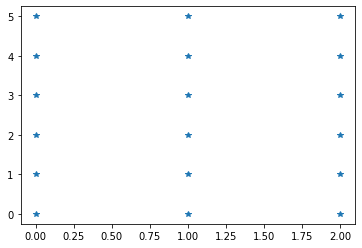

In [5]:
E = Edificio(3.2, (6, 7), 0.5, 0.5, 0.6, 0.5, 2.5e7, 2.5e7, 90, 0, 5)
vector = np.array([[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[2, 0],[2, 1],[2, 2],
                   [2, 3],[2, 4],[2, 5]])
# vector = np.array([[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[2, 0],[2, 1],[2, 2],
#                    [2, 3],[2, 4],[2, 5],[3, 0],[3, 1],[3, 2],[3, 3],[3, 4],[3, 5],[4, 0],[4, 1],[4, 2],[4, 3],[4, 4],[4, 5],
#                    [5, 0],[5, 1],[5, 2],[5, 3],[5, 4],[5, 5]])
plt.plot(vector[:,0], vector[:,1], '*')
m = E.ensamblar_texto(vector, 3, 'y')
E.Global();
E.ensamblar()
print('Suma ensamblada: ',E.ensamblada.sum(), '\nShape ensamblada: ',  E.ensamblada.shape)
E.condensar()
print('Suma condensada: ',E.condensada.sum(), '\nShapecondensada: ', E.condensada.shape)

# Ensamblada 108x108

Suma ensamblada:  25898437.499999993 
Shape ensamblada:  (108, 108)
Suma condensada:  233719.93753420585 
Shapecondensada:  (5, 5)


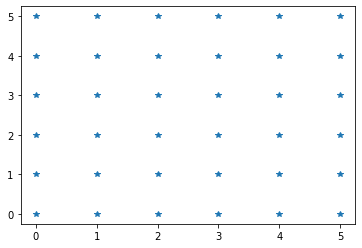

In [6]:
vector = np.array([[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[2, 0],[2, 1],[2, 2],
                   [2, 3],[2, 4],[2, 5],[3, 0],[3, 1],[3, 2],[3, 3],[3, 4],[3, 5],[4, 0],[4, 1],[4, 2],[4, 3],[4, 4],[4, 5],
                   [5, 0],[5, 1],[5, 2],[5, 3],[5, 4],[5, 5]])
plt.plot(vector[:,0], vector[:,1], '*')
m = E.ensamblar_texto(vector, 6, 'x')
E.Global();
E.ensamblar()
print('Suma ensamblada: ',E.ensamblada.sum(), '\nShape ensamblada: ',  E.ensamblada.shape)
E.condensar()
print('Suma condensada: ',E.condensada.sum(), '\nShapecondensada: ', E.condensada.shape)

# Matriz de Masa

In [94]:
E.Masa(1500, 600, dict(zip(('x', 'y'),(0, 0))))
E.masa.sum()
print('Suma masa: ',E.masa.sum(), '\nShape masa: ', E.masa.shape)

Suma masa:  258720.0 
Shape masa:  (15, 15)


# Matriz de Transformación

In [95]:
E.transformacion()
print('Suma rigidez: ',E.rigidez.sum(), '\nShape rigidez: ', E.rigidez.shape)

Suma rigidez:  94419419.90456918 
Shape rigidez:  (15, 15)


In [96]:
self = E

In [97]:
eigvalues, phi  = np.linalg.eig(np.linalg.inv(self.masa).dot(self.rigidez.astype(float)))
phi.sum()

-0.2857495963475858

In [98]:
phi = phi[:, pd.DataFrame(eigvalues, columns=['values']).sort_values('values').index]
eigvalues = eigvalues[pd.DataFrame(eigvalues, columns=['values']).sort_values('values').index]
omega = eigvalues ** 0.5

### Normalizamos los vectores propios con respecto a la masa

In [99]:
for i in range(len(phi)):
    phi[:, i] = 1/(phi[:, i].T .dot(self.masa) .dot(phi[:, i]))**0.5 * phi[:, i]

### Comprobamos que todo marche bien

In [100]:
self.comprobacion1 = pd.DataFrame(phi.T .dot(self.masa).dot(phi).round(5))
self.comprobacion2 = pd.DataFrame(phi.T .dot(self.rigidez.astype(float)).dot(phi))

# Modos de Vibracion

In [101]:
import scipy.interpolate 

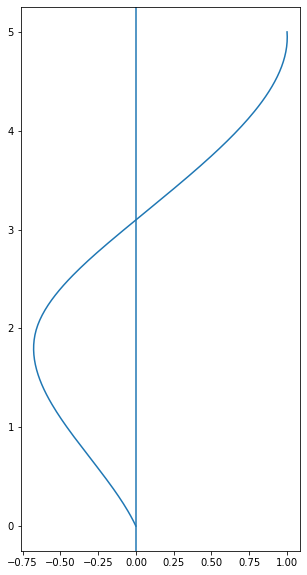

In [120]:
# en x
modo = 2
dire = 'x'
dir_dic = dict(zip(('x', 'y', 'z'), (0,1, 2)))
x = phi[:, dir_dic[dire]+3*(modo-1)][list(range(dir_dic[dire], len(phi), 3))]
x = np.r_[[0], 1/x[0]*x[::-1]]
y = list(range(self.pisos+1))
y_smooth = np.linspace(0, self.pisos, 200)
x_smooth = scipy.interpolate.interp1d(y, x, kind='cubic')


plt.figure(figsize=(5, 10))
plt.plot(x_smooth(y_smooth), y_smooth)
plt.axvline(0)